In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

In [3]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc, roc_curve
from imblearn.over_sampling import ADASYN

Using TensorFlow backend.


In [4]:
def pre_PCA():
    dataset = pd.read_csv('data2.csv') #데이터셋 로딩, 간질환자의 발작 and 정상

    X = dataset.iloc[:,1:179].values
    y = dataset.iloc[:,179:].values

    for i in range(len(y)): #one-hot encoding
        if y[i] == 1 : 
            y[i] = 1
        else :
            y[i] = 0
        
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0) #8:2로 나눔
    
    #ADASYN 비대칭 데이터 문제 해결
    ad = ADASYN()
    X_train, y_train = ad.fit_sample(X_train, y_train)


    #주성분 추출
    pca = PCA() 
    pca.fit(X)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95)+1
    print('best dim =',d)

    pca = PCA(n_components= 39)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.fit_transform(X_test)
    
    return X_train_pca, X_test_pca, y_train, y_test

In [5]:
def pre_IPCA():
    dataset = pd.read_csv('data2.csv') #데이터셋 로딩, 간질환자의 발작 and 정상

    X = dataset.iloc[:,1:179].values
    y = dataset.iloc[:,179:].values

    for i in range(len(y)): #one-hot encoding
        if y[i] == 1 : 
            y[i] = 1
        else :
            y[i] = 0
        
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0) #8:2로 나눔

    #ADASYN 비대칭 데이터 문제 해결
    ad = ADASYN()
    X_train, y_train = ad.fit_sample(X_train, y_train)

    #주성분 추출
    n_batches = 10
    inc_pca = IncrementalPCA(n_components=39)

    for X_batch in np.array_split(X_train, n_batches):
        inc_pca.partial_fit(X_batch)
    
    for X_batch in np.array_split(X_test, n_batches):
        inc_pca.partial_fit(X_batch)
    
    X_train_ipca = inc_pca.transform(X_train)
    X_test_ipca = inc_pca.transform(X_test)
    
    return X_train_ipca, X_test_ipca, y_train, y_test

In [6]:
def clf(opt ,X_train, X_test,y_train, y_test, epochs):
    model = models.Sequential()
    model.add(layers.Dense(32, activation = 'relu', input_shape=(39,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer = opt,
                 loss='mse',
                 metrics=[metrics.binary_accuracy])

    history = model.fit(X_train,
                       y_train,
                       epochs = epochs,
                       batch_size = 10,
                       validation_data=(X_test,y_test))
    return history,model

In [9]:
def val_loss_acc(history, opt) :
    history_dict = history.history #딕셔너리를 만들어줍니다.
    history_dict.keys()
    history_dict = history.history #훈련과 검증 손실 그래프를 그려줍니다.
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(opt)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

    plt.clf() #그래프를 초기화합니다.
    acc = history_dict['binary_accuracy'] #훈련과 검증 정확도를 그려줍니다.
    val_acc = history_dict['val_binary_accuracy']
    plt.plot(epochs, acc,'r',label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(opt)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

In [10]:
def roc(model, opt) :
    pred_df = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_df)
    roc_auc = auc(fpr, tpr)
    
    # Plotting ROC Curve
    plt.title(opt)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.05, 1.03])
    plt.ylim([-0.05, 1.03])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # plt.savefig('SMOTE_lr_roc.png')
    plt.show()

C:\Users\wonjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train on 3692 samples, validate on 920 samples
Epoch 1/20
3692/3692 [==============================] - 4s 965us/step - loss: 0.3212 - binary_accuracy: 0.5311 - val_loss: 0.3052 - val_binary_accuracy: 0.5293
Epoch 2/20
3692/3692 [==============================] - 2s 419us/step - loss: 0.2746 - binary_accuracy: 0.5531 - val_loss: 0.2535 - val_binary_accuracy: 0.5489
Epoch 3/20
3692/3692 [==============================] - 2s 414us/step - loss: 0.2522 - binary_accuracy: 0.5441 - val_loss: 0.2495 - val_binary_accuracy: 0.5380
Epoch 4/20
3692/3692 [==============================] - 1s 406us/step - loss: 0.2423 - binary_accuracy: 0.5804 - val_loss: 0.2388 - val_binary_accuracy: 0.5848
Epoch 5/20
3692/3692 [==============================] - 2s 446us/step - loss: 0.2337 - binary_accuracy: 0.5913 - val_loss: 0.2373 - val_binary_accuracy: 0.5728
Epoch 6/20
3692/3692 [==============================] - 2s 439us/step - loss: 0.2238 - binary_accuracy: 0.6124 - val_loss: 0.2213 - val_binary_accuracy: 

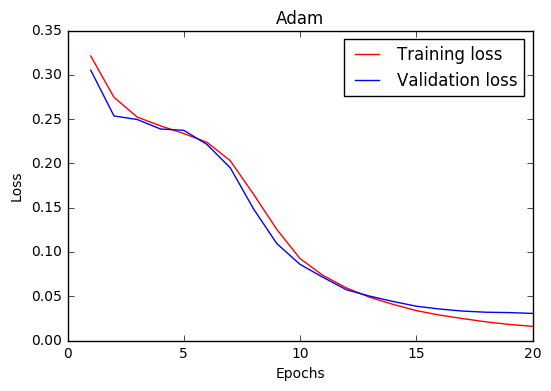

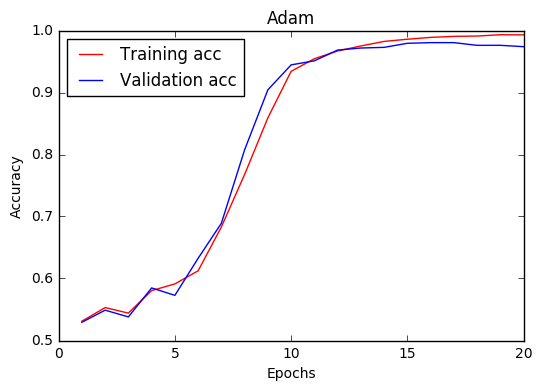

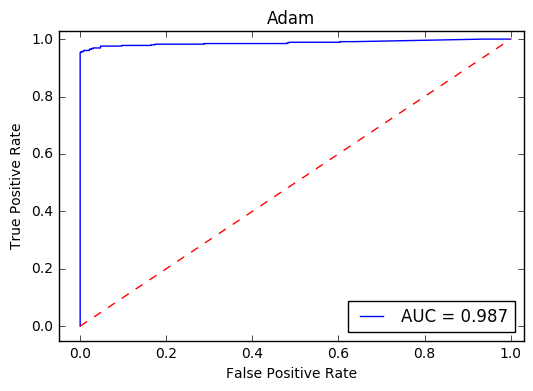

In [15]:
X_train, X_test, y_train, y_test = pre_IPCA()
opt = 'Adam'
history,model = clf(opt, X_train, X_test, y_train, y_test, 20) #분류기, X_train, X_test, y_train, y_test, epoch 순서로 넣으시면 됩니다.
val_loss_acc(history, opt)
roc(model, opt)

Train on 3692 samples, validate on 920 samples
Epoch 1/20
3692/3692 [==============================] - 7s 2ms/step - loss: 0.2586 - binary_accuracy: 0.5382 - val_loss: 0.2557 - val_binary_accuracy: 0.5543
Epoch 2/20
3692/3692 [==============================] - 2s 530us/step - loss: 0.2560 - binary_accuracy: 0.5298 - val_loss: 0.2521 - val_binary_accuracy: 0.5120
Epoch 3/20
3692/3692 [==============================] - 2s 553us/step - loss: 0.2493 - binary_accuracy: 0.5114 - val_loss: 0.2513 - val_binary_accuracy: 0.5120
Epoch 4/20
3692/3692 [==============================] - 2s 545us/step - loss: 0.2491 - binary_accuracy: 0.5100 - val_loss: 0.2395 - val_binary_accuracy: 0.5522
Epoch 5/20
3692/3692 [==============================] - 2s 548us/step - loss: 0.2443 - binary_accuracy: 0.5217 - val_loss: 0.2454 - val_binary_accuracy: 0.5250
Epoch 6/20
3692/3692 [==============================] - 2s 540us/step - loss: 0.2134 - binary_accuracy: 0.6254 - val_loss: 0.3213 - val_binary_accuracy: 0.

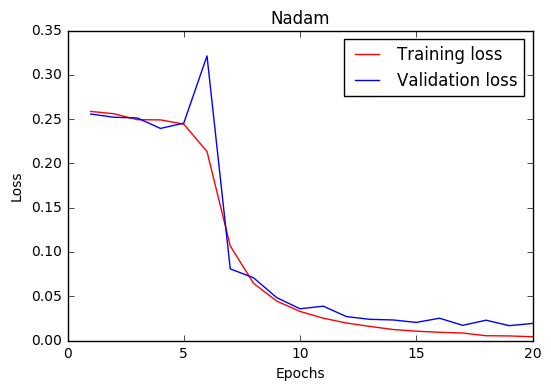

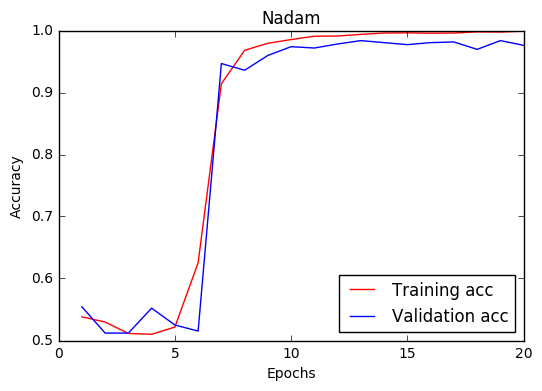

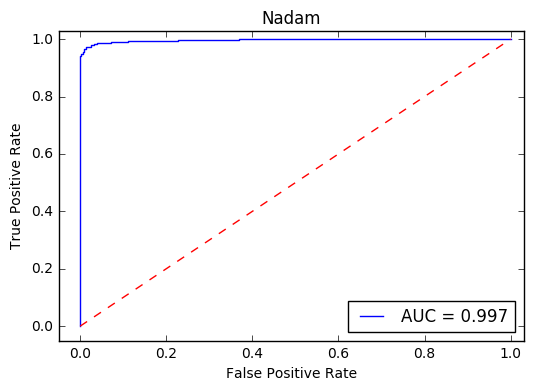

In [31]:
opt = 'Nadam'
history,model = clf(opt, X_train, X_test, y_train, y_test, 20) #분류기, X_train, X_test, y_train, y_test, epoch 순서로 넣으시면 됩니다.
val_loss_acc(history, opt)
roc(model, opt)

Train on 3692 samples, validate on 920 samples
Epoch 1/20
3692/3692 [==============================] - 8s 2ms/step - loss: 0.4722 - binary_accuracy: 0.5214 - val_loss: 0.4876 - val_binary_accuracy: 0.5109
Epoch 2/20
3692/3692 [==============================] - 2s 577us/step - loss: 0.4808 - binary_accuracy: 0.5179 - val_loss: 0.4678 - val_binary_accuracy: 0.5304
Epoch 3/20
3692/3692 [==============================] - 2s 574us/step - loss: 0.4456 - binary_accuracy: 0.5523 - val_loss: 0.4267 - val_binary_accuracy: 0.5696
Epoch 4/20
3692/3692 [==============================] - 2s 669us/step - loss: 0.3933 - binary_accuracy: 0.5953 - val_loss: 0.3704 - val_binary_accuracy: 0.6109
Epoch 5/20
3692/3692 [==============================] - 2s 602us/step - loss: 0.3733 - binary_accuracy: 0.6148 - val_loss: 0.3811 - val_binary_accuracy: 0.6076
Epoch 6/20
3692/3692 [==============================] - 2s 581us/step - loss: 0.3553 - binary_accuracy: 0.6306 - val_loss: 0.3456 - val_binary_accuracy: 0.

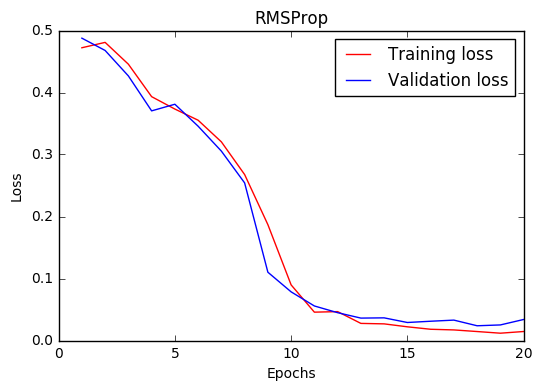

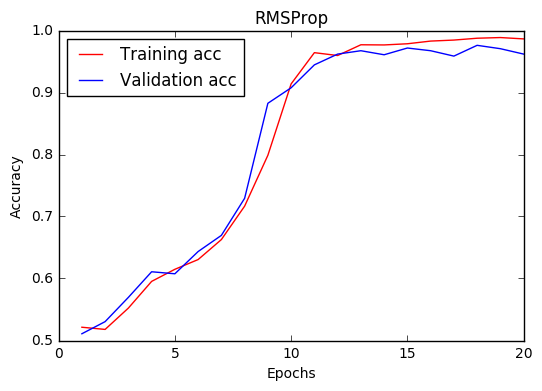

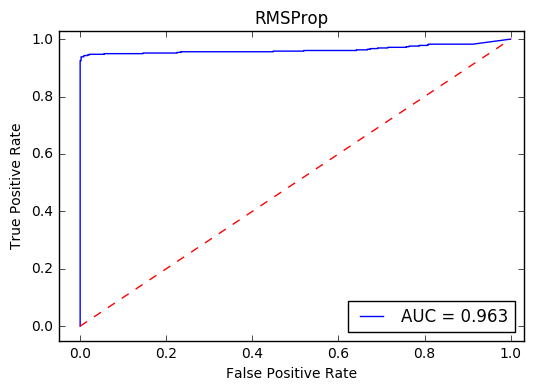

In [43]:
opt = 'RMSProp'
history,model = clf(opt, X_train, X_test, y_train, y_test, 20) #분류기, X_train, X_test, y_train, y_test, epoch 순서로 넣으시면 됩니다.
val_loss_acc(history, opt)
roc(model, opt)

Train on 3692 samples, validate on 920 samples
Epoch 1/20
3692/3692 [==============================] - 4s 1ms/step - loss: 0.3835 - binary_accuracy: 0.5138 - val_loss: 0.3022 - val_binary_accuracy: 0.5630
Epoch 2/20
3692/3692 [==============================] - 2s 466us/step - loss: 0.2827 - binary_accuracy: 0.5463 - val_loss: 0.2497 - val_binary_accuracy: 0.5652
Epoch 3/20
3692/3692 [==============================] - 2s 433us/step - loss: 0.2499 - binary_accuracy: 0.5498 - val_loss: 0.2415 - val_binary_accuracy: 0.5641
Epoch 4/20
3692/3692 [==============================] - 2s 453us/step - loss: 0.2408 - binary_accuracy: 0.5525 - val_loss: 0.2400 - val_binary_accuracy: 0.5576
Epoch 5/20
3692/3692 [==============================] - 2s 445us/step - loss: 0.2369 - binary_accuracy: 0.5577 - val_loss: 0.2390 - val_binary_accuracy: 0.5630
Epoch 6/20
3692/3692 [==============================] - 2s 482us/step - loss: 0.2303 - binary_accuracy: 0.5788 - val_loss: 0.2312 - val_binary_accuracy: 0.

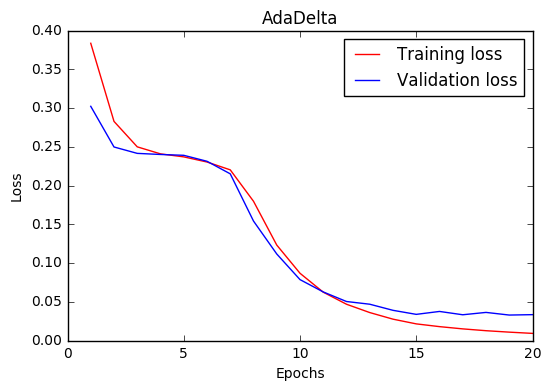

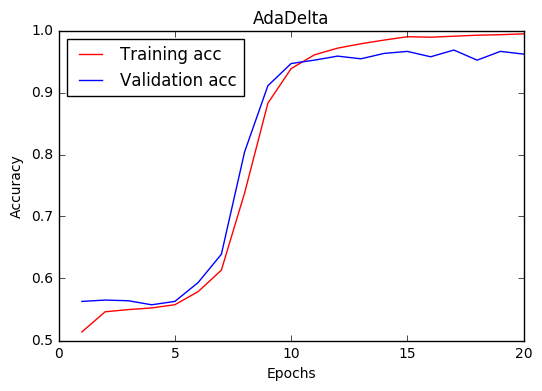

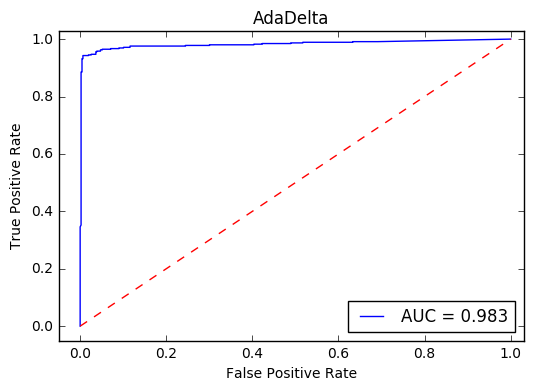

In [18]:
opt = 'AdaDelta'
history,model = clf(opt, X_train, X_test, y_train, y_test, 20) #분류기, X_train, X_test, y_train, y_test, epoch 순서로 넣으시면 됩니다.
val_loss_acc(history, opt)
roc(model, opt)